## Read Dataset (download)


In [ ]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 5.5 MB/s eta 0:00:00


In [ ]:

from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Removing noise by applying BandPass fliter

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA

def filter_sig(record_name):
    # Load the ECG recording and associated metadata
    record = wfdb.rdrecord(record_name)

    # Extract the ECG signal from all channels
    ecg_signal = record.p_signal

    # Define the filter cut-off frequencies in Hz
    lowcut = 1.0
    highcut = 40.0

    # Define the filter order
    order = 4

    # Compute the Nyquist frequency
    nyq = 0.5 * record.fs

    # Compute the filter cut-off frequencies in normalized units
    low = lowcut / nyq
    high = highcut / nyq

    # Compute the filter coefficients using a Butterworth filter for each channel
    filtered_signal = np.zeros_like(ecg_signal)
    for i in range(ecg_signal.shape[1]):
        b, a = butter(order, [low, high], btype='band')
        filtered_signal[:, i] = filtfilt(b, a, ecg_signal[:, i])
    return filtered_signal

# Pan Tompkins algorithm for QRS complex detection


In [ ]:
import numpy as np
import scipy.signal

def pan_tompkins(ecg, sampling_rate):
  """
  Pan-Tompkins algorithm for QRS detection in ECG signals.

  Args:
    ecg: The ECG signal as a NumPy array.
    sampling_rate: The sampling rate of the ECG signal in Hz.

  Returns:
    A NumPy array of the detected QRS locations.
  """

  # Bandpass filter the ECG signal.
  w1 = 5 * 2 / sampling_rate
  w2 = 15 * 2 / sampling_rate
  b, a = scipy.signal.butter(4, [w1, w2], 'bandpass')
  ecg_bp = scipy.signal.filtfilt(b, a, ecg)

  # Compute the first derivative of the filtered ECG signal.
  d_ecg_bp = scipy.fftpack.diff(ecg_bp)

  # Compute the squared magnitude of the first derivative.
  m = np.square(d_ecg_bp)

  # Compute the threshold.
  threshold = np.mean(m) + 3 * np.std(m)

  # Find the peaks in the squared magnitude.
  peaks = np.where(m > threshold)[0]
  #print(peaks)
  # Return the QRS locations.
  return peaks


# P Wave Peak Detection

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_local_maximum(ecg_signal, qrs_onset_index, sampling_rate, search_window_width=0.2):
    search_window_samples = int(search_window_width * sampling_rate)
    search_window_start = qrs_onset_index
    search_window_end = qrs_onset_index - search_window_samples

    # Adjust the search window if it exceeds the signal boundaries
    if search_window_end < 0:
        search_window_end = 0

    search_window = ecg_signal[search_window_end:search_window_start]
    local_max_index = np.argmax(search_window)

    # Convert the local maximum index back to the original signal index
    local_max_index = search_window_end + local_max_index

    return local_max_index


# T wave Peak Detection

In [ ]:
import numpy as np

def detect_t_wave(ecg_signal, offset_index, sampling_rate, search_window_width=0.4):
    search_window_samples = int(search_window_width * sampling_rate)
    search_window_start = offset_index
    search_window_end = offset_index + search_window_samples

    search_window = ecg_signal[search_window_start:search_window_end]


    # Finding the local maximum within the search window
    t_wave_index = np.argmax(search_window)

    # Calculate the index within the original signal
    t_wave_index += search_window_start

    return t_wave_index


In [ ]:
def visualize_fiducial(ecg_segment, p_peak, p_onset, p_offset, t_peak, t_onset, t_offset, qrs_onset, qrs_offset):
    import numpy as np
    import matplotlib.pyplot as plt

    # Load ECG signal (replace with your own data)
    ecg_signal =  ecg_segment

    # Example indices (replace with your own indices)
    p_wave_onset_index = p_onset
    p_wave_offset_index = p_offset
    p_wave_peak_index = p_peak
    qrs_onset_index = qrs_onset
    qrs_offset_index = qrs_offset
    t_wave_onset_index = t_onset
    t_wave_offset_index = t_offset
    t_wave_peak_index = t_peak

    # Generate time axis based on the length of the ECG signal
    duration = len(ecg_signal) / 1000
    t = np.arange(0, duration, 1/1000)

    # Plot ECG signal with annotations
    plt.figure(figsize=(12, 6))
    plt.plot(t, ecg_signal, label='ECG Signal')
    plt.axvline(x=t[p_wave_onset_index], color='r', linestyle='--', label='P Wave Onset')
    plt.axvline(x=t[p_wave_offset_index], color='g', linestyle='--', label='P Wave Offset')
    plt.axvline(x=t[p_wave_peak_index], color='b', linestyle='--', label='P Wave Peak')
    plt.axvline(x=t[qrs_onset_index], color='m', linestyle='--', label='QRS Onset')
    plt.axvline(x=t[qrs_offset_index], color='y', linestyle='--', label='QRS Offset')
    plt.axvline(x=t[t_wave_onset_index], color='c', linestyle='--', label='T Wave Onset')
    plt.axvline(x=t[t_wave_offset_index], color='k', linestyle='--', label='T Wave Offset')
    plt.axvline(x=t[t_wave_peak_index], color='purple', linestyle='--', label='T Wave Peak')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()


# Wave (Onset, Offset) detectoin by finding local minimas.

In [ ]:
import numpy as np

def detect_wave_onset_offset(ecg_signal, p_peak_index, sampling_rate, search_window_width=0.2, offset_window_width=0.05):
    search_window_samples = int(search_window_width * sampling_rate)
    search_window_start = p_peak_index - search_window_samples
    search_window_end = p_peak_index + search_window_samples

    search_window = ecg_signal[search_window_start:search_window_end]

    # Find the onset point
    if len(search_window) != 0:
      p_wave_onset_index = np.argmin(search_window[:p_peak_index - search_window_start])
      p_wave_onset_index += search_window_start
    else:
      p_wave_onset_index = p_peak

    # Create a narrower window for offset detection
    offset_window_samples = int(offset_window_width * sampling_rate)
    offset_search_window_start = p_peak_index
    offset_search_window_end = p_peak_index + offset_window_samples

    offset_search_window = search_window[offset_search_window_start - search_window_start:offset_search_window_end - search_window_start]
    if len(offset_search_window) != 0:
      # Find the offset point
      min_value = np.min(offset_search_window)
      offset_indices = np.where(offset_search_window == min_value)[0]
      p_wave_offset_index = offset_indices[0] + offset_search_window_start
    else:
      p_wave_offset_index = p_peak
    return p_wave_onset_index, p_wave_offset_index


# Feature extraction

In [ ]:
def extract_fiducial(ecg_segment, sampling_rate):
  
  # finding QRS Complex
  qrs_Points = pan_tompkins(ecg_segment, sampling_rate)
  qrs_onset, qrs_offset = qrs_Points[1], qrs_Points[-2]
  #print(qrs_onset, qrs_offset)

  # Finding P Wave (Peak, Onset, Offset)
  p_peak =  find_local_maximum(ecg_segment, qrs_onset, sampling_rate, search_window_width=0.2)
  #print("P")
  p_onset, p_offset = detect_wave_onset_offset(ecg_segment, p_peak, sampling_rate, search_window_width=0.2, offset_window_width=0.05)

  #print("T")
  # Finding T wave (Peak, Onset, Offset)
  t_peak = detect_t_wave(ecg_segment, qrs_offset, sampling_rate, search_window_width=0.4)
  t_onset, t_offset = detect_wave_onset_offset(ecg_segment, t_peak, sampling_rate, search_window_width=0.15, offset_window_width=0.08)

  return [p_peak, p_onset, p_offset, t_peak, t_onset, t_offset, qrs_onset, qrs_offset]


[  0 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 999]
274 289
P
T


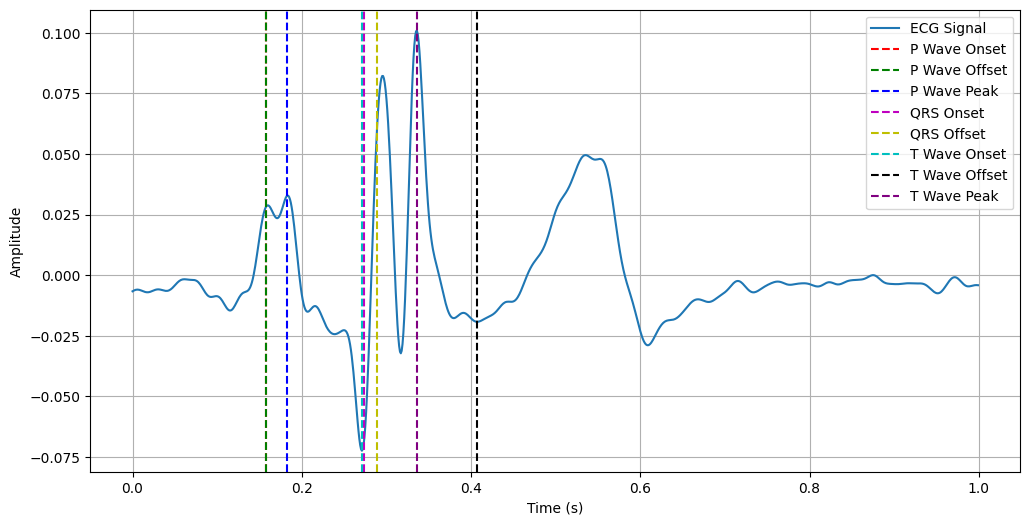

# Data Preparation

In [ ]:
def segment_sig(signal):
    segment_size = 1000

    # Calculate the number of segments
    num_segments = signal.shape[0] // segment_size

    # Create an empty numpy array to store the segments
    segments = np.empty((num_segments, segment_size, signal.shape[1]))

    # Split the signal into segments
    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = start_idx + segment_size
        segments[i] = signal[start_idx:end_idx]
    return segments

In [ ]:
def transform_data(signal):
  transformed_signal = []
  for segment in range(len(signal)):
      feature_vector = []
      for channel in ([13]):
         #print(segment,channel)
         feature_vector.append(extract_fiducial(signal[segment, :, channel], 1000))
      transformed_signal.append(feature_vector)
  return np.array(transformed_signal)

In [ ]:
from sklearn.model_selection import train_test_split
def prepare_data(patient_no,transformed_signal):
    sig = np.zeros((len(transformed_signal),(8)+1))
    for i in range(len(transformed_signal)): 
        x= np.append(transformed_signal[i].flatten(), patient_no)
        sig[i] = x
    sig.shape
    X=sig[:,:1500]
    y=sig[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:
def PCA_sig(X_train,X_test):
    num_components = 8
    pca_signal = np.zeros((len(X_train),num_components))

    pca = PCA(n_components=num_components)
    pca =pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    # Print explained variance ratio for each principal component
    #print('Explained variance ratio for hearbeat {}: {}'.format(i+1, pca.explained_variance_ratio_))
    print(sum(pca.explained_variance_ratio_))
    return X_train,X_test

In [ ]:
import pandas as pd
def add_to_df(X_train,X_test,y_train,y_test,df):
    # Create dataframes for each array
    train_df = pd.DataFrame(X_train, columns=['Feature_{}'.format(i) for i in range(X_train.shape[1])])
    train_df['Target'] = y_train

    test_df = pd.DataFrame(X_test, columns=['Feature_{}'.format(i) for i in range(X_test.shape[1])])
    test_df['Target'] = y_test

    # Concatenate the train and test dataframes
    combined_df = pd.concat([df,train_df, test_df], axis=0).reset_index(drop=True)

    # Print the combined dataframe
    return combined_df

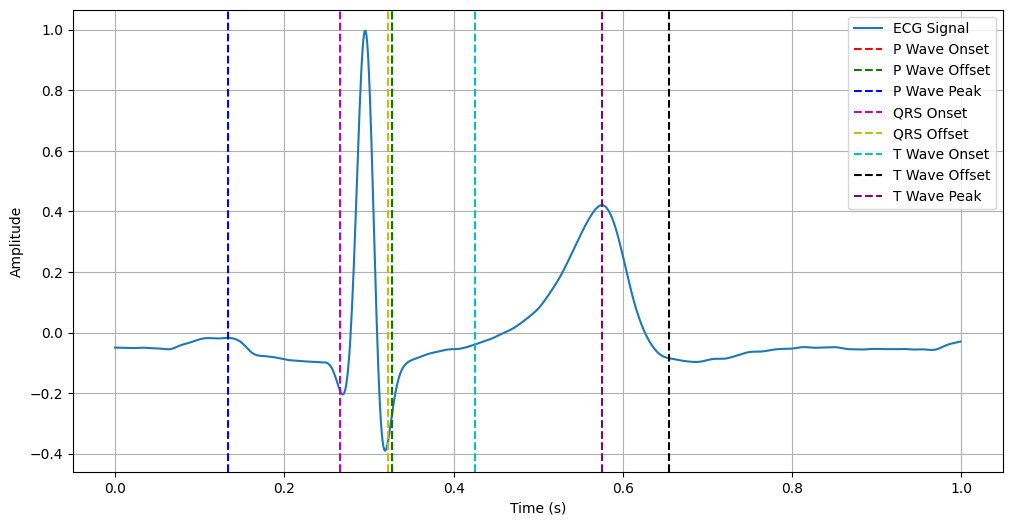

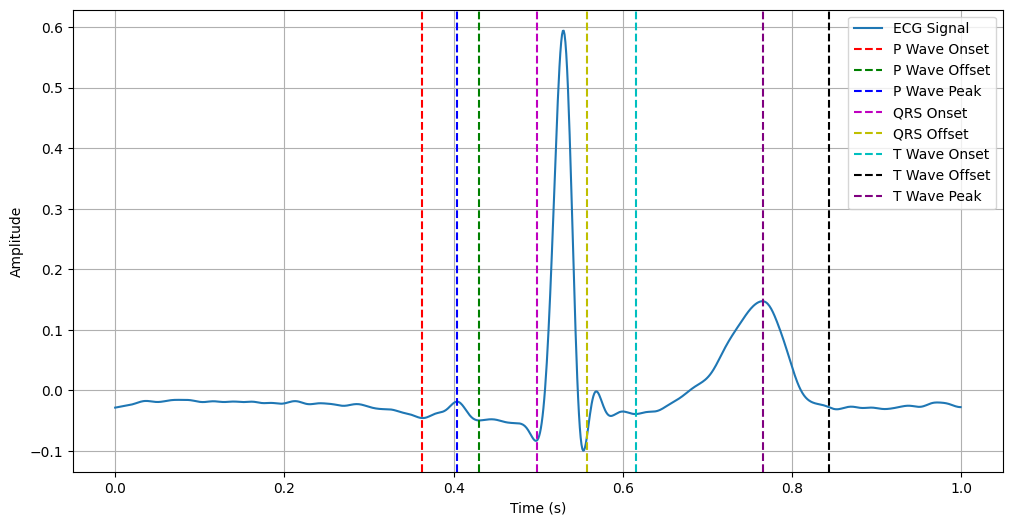

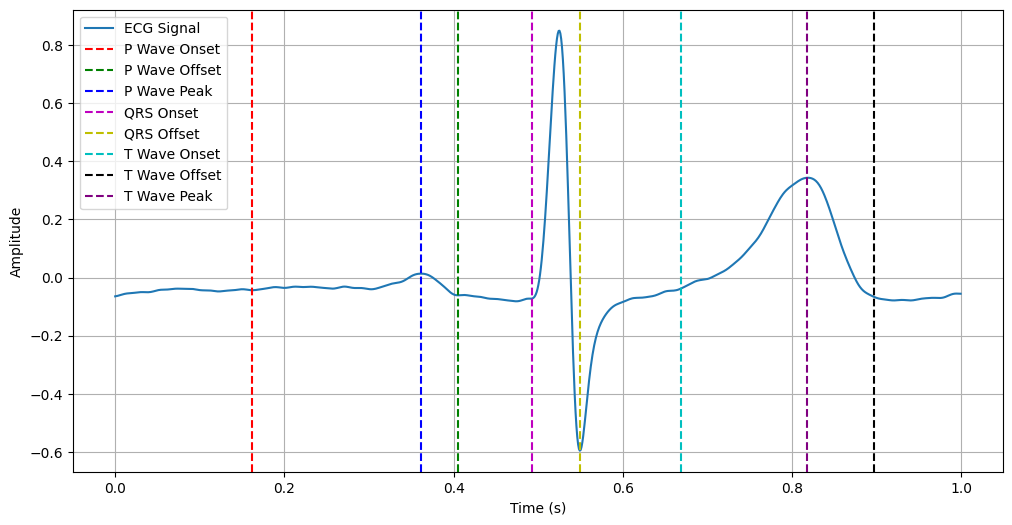

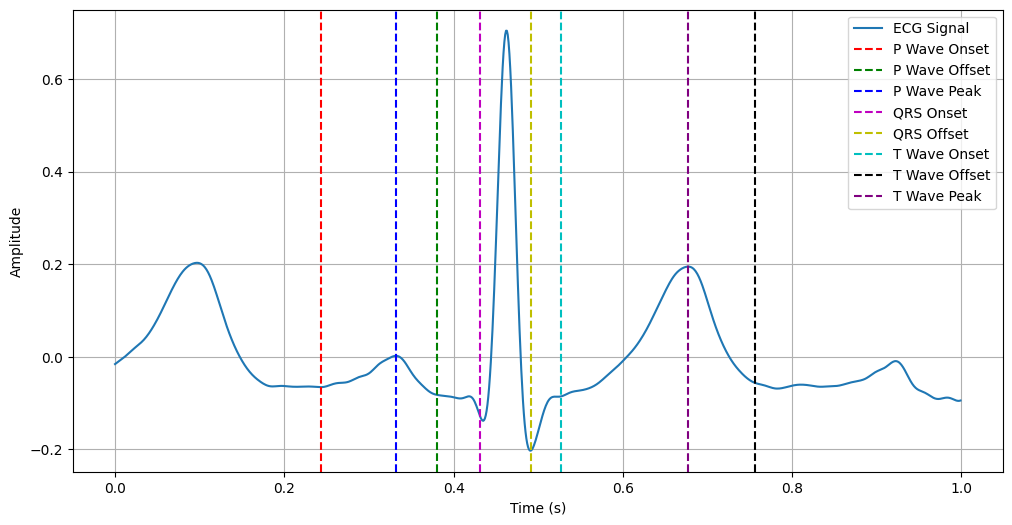

In [ ]:
patients = ['patient174','patient180','patient185','patient214']
records=   ['s0325lre','s0476_re','s0336lre','s0436_re']
df = pd.DataFrame()
root = "/content/gdrive/My Drive/HCI_Project/"
for patient in range(len(patients)):
  record_name = root + patients[patient] + "/" + records[patient]
  filtered_signal = filter_sig(record_name)
  ecg_segment = filtered_signal[500:1500, 11]
  p_peak, p_onset, p_offset, t_peak, t_onset, t_offset, qrs_onset, qrs_offset = extract_fiducial(ecg_segment, 1000)
  visualize_fiducial(ecg_segment, p_peak, p_onset, p_offset, t_peak, t_onset, t_offset, qrs_onset, qrs_offset)

In [ ]:
patients = ['patient174','patient180','patient185','patient214']
records=   ['s0325lre','s0476_re','s0336lre','s0436_re']
df = pd.DataFrame()
root = "/content/gdrive/My Drive/HCI_Project/"
for patient in range(len(patients)):
  record_name = root + patients[patient] + "/" + records[patient]
  filtered_signal = filter_sig(record_name)
  
  segmented_signal = segment_sig(filtered_signal[500:,:])

  transformed_signal = transform_data(segmented_signal)
  print(transformed_signal.shape)

  patient_no = patients[patient][7:]

  X_train, X_test, y_train, y_test = prepare_data(patient_no,transformed_signal)

  X_train,X_test = PCA_sig(X_train,X_test)

  df = add_to_df(X_train,X_test,y_train,y_test,df)

df


(114, 1, 8)
1.0
(119, 1, 8)
1.0000000000000002
(114, 1, 8)
1.0
(119, 1, 8)
0.9999999999999998


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Target
0,670.017255,-230.092987,163.132157,104.492074,-14.656298,11.369855,-9.498598,-8.150096,174.0
1,804.880865,-135.726438,112.828350,-17.206093,-0.530934,-26.303870,11.085636,-17.385798,174.0
2,-4.880509,-3.992898,-162.917094,35.838669,7.563729,-3.022668,4.605961,1.926672,174.0
3,788.105408,-139.123519,103.142919,-11.644226,-1.933324,-16.707329,4.780828,1.914230,174.0
4,-466.574865,-53.576678,15.533748,-8.809737,-23.970693,0.077823,-0.546791,0.924781,174.0
...,...,...,...,...,...,...,...,...,...
461,187.623614,-258.698642,110.697635,-13.063889,47.359162,44.832166,-15.380410,-14.665001,214.0
462,103.241275,-376.152713,57.102755,129.595223,7.810045,25.533660,-9.373073,-0.506044,214.0
463,101.466385,187.890965,-135.801436,-16.490581,-19.280944,32.573118,11.742782,15.372725,214.0
464,-301.267339,-340.064861,-5.538858,-54.669948,-20.443853,-12.183377,-11.133654,-5.492626,214.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1],df['Target'], test_size=0.2, random_state=42,shuffle=True)

In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.9,max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8617021276595744

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC() # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.5106382978723404

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 94 points : 68


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
best_model = None
mx = 0
for model in range(100):
  # Create a Random Forest classifier
  rf = RandomForestClassifier(n_estimators=350)

  # Train the model on the training data
  rf.fit(X_train, y_train)

  # Make predictions on the test data
  y_pred = rf.predict(X_test)
  accuracy = metrics.accuracy_score(y_test, y_pred)
  
  if accuracy > mx:
    mx = accuracy
    best_model = rf
  # Model Accuracy: how often is the classifier correct?
  print("Accuracy:",accuracy)

Accuracy: 0.9680851063829787
Accuracy: 0.9680851063829787
Accuracy: 0.9893617021276596
Accuracy: 0.9787234042553191
Accuracy: 0.9787234042553191
Accuracy: 0.9893617021276596
Accuracy: 0.9893617021276596
Accuracy: 0.9893617021276596
Accuracy: 0.9787234042553191
Accuracy: 0.9787234042553191
Accuracy: 0.9680851063829787
Accuracy: 0.9787234042553191
Accuracy: 0.9680851063829787
Accuracy: 0.9787234042553191
Accuracy: 0.9787234042553191
Accuracy: 0.9787234042553191
Accuracy: 0.9893617021276596
Accuracy: 0.9680851063829787
Accuracy: 0.9680851063829787
Accuracy: 0.9893617021276596
Accuracy: 0.9893617021276596
Accuracy: 0.9787234042553191
Accuracy: 0.9787234042553191
Accuracy: 0.9893617021276596
Accuracy: 0.9787234042553191
Accuracy: 0.9893617021276596
Accuracy: 0.9787234042553191
Accuracy: 0.9787234042553191
Accuracy: 0.9787234042553191
Accuracy: 0.9787234042553191
Accuracy: 0.9893617021276596
Accuracy: 0.9787234042553191
Accuracy: 0.9893617021276596
Accuracy: 0.9787234042553191
Accuracy: 0.98

In [ ]:
from joblib import dump, load
dump(best_model, 'Model.joblib')

['Model.joblib']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9893617021276596


In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9680851063829787
